<h1>Demo 1: QCS EVALUATION </h1>

<p>Here you can evaluate your Quality Control Standards for no normalization data, Total Ion Ccount normalization data, and Internal Standard normalization data. For Pipeline #1, we will evaluate Quality Control Standard using Relative Standard Deviation (RSD) calculation and will have visualization of intensity plot, violin plot of Quality Control Standards to assess their variation throughout intra/interday batch. You can change the file path and file name accordingly and change the sample_set based on the names of your tissue samples in your dataset. It is recommended to run the pipeline in order then go to certain parts to look at the results again</p>

0. [Packages to Download](#package_1)
1. [Input_Information](#input_1)
2. [Preprocessing Datasets](#preprocessing_1)
3. [RSD Calculation](#rsd_1)
6. [Visualization](#visualization_1)
7. [Output](#output_1)

<h1><u><b> Packages to Download </b></u></h1>
<a id="package_1"></a>

In [5]:
## Packages for RSD overview table ##
install.packages("htmltools")
install.packages("kableExtra")
install.packages("IRdisplay")

## Packages for Violin plot ##
install.packages("ggplot2")
install.packages("dplyr")
install.packages("RColorBrewer")

## Package for excel sheet creating ##
install.packages("openxlsx")

## Package for overview output ##
install.packages("png")

cat("\033[1mSuccessfully Downloaded Packages\033[0m\n")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



Successfully Downloaded Packages


<h1><u><b>Input Information</b></u></h1>
<a id="input_1"></a>
<u><b>Upload these files in input folder</b></u>

1) <b>Data matrix for no normalization </b> (csv file obtained from SciLs lab directly)
2) <b>Data matrix for TIC normalization </b> (csv file obtained from SciLs lab directly)
3) <b>Batch info (csv file with batch information for sample construction)</b> (check the given example file *must have "injection.order" and "batch" column)

<u><b>These will need to be changed in the cell below</b></u>

4) <b> File path for above 3 files </b>
5) <b>QCS Analytes mass-to-charge ratio (m/z) values </b> (ie: propranolol 260.16, D7-propranolol 267.14) (*if using VS code, input at the top bar)
6) <b>Sample set (tissue sample names, check the example given)</b>

In [6]:
### Please edit the file path, file name ###
# Please only edit areas with ## ##

no_normalization_data_1 <- read.csv("input/119feature_T&QCS_BaseRemoval_noNorm.csv", ## change file path ##
                                  header = FALSE,
                                  check.name = FALSE,
                                  stringsAsFactors = FALSE)

TIC_normalization_data_1 <- read.csv("input/119feature_T&QCS_BaseRemoval_TICNorm.csv", ## change file path ##
                                   header = FALSE,
                                   check.name = FALSE,
                                   stringsAsFactors = FALSE) 

propranolol_mz_value_1 <- as.numeric(readline("Please enter Propranolol m/z value: ")) ## ie: 260.186 ##

d7_propranolol_mz_value_1 <- as.numeric(readline("Please enter D7-propranolol m/z value: ")) ## ie: 267.187 ##

batch_info_1 <- read.csv("input/batch_info_TIC.csv", ## change file path ##
                       header = TRUE,
                       check.name = FALSE,
                       stringsAsFactors = FALSE) 

cat("\033[1mChange the sample_set accordingly to the dataset!\033[0m\n")

sample_set_1 <- c("ChickenHeart", "ChickenLiver", "GoatLiver") ## change tissue sample names ##

Enter Propranolol m/z value:  260.186
Enter D7-propranolol m/z value:  267.187


Change the sample_set accordingly to the dataset!


In [7]:
# Check if "injection.order" column exists
if ("injection.order" %in% colnames(batch_info_1)) {
    cat("\033[1mColumn 'injection.order' exists\033[0m\n")
} else {
    cat("\033[1mColumn 'injection.order' does not exist. Please check/edit colname for batch_info\033[0m\n")
}

if ("batch" %in% colnames(batch_info_1)) {
    cat("\033[1mColumn 'batch' exists.\033[0m\n")
} else {
    cat("\033[1mColumn 'batch' does not exist. Please check/edit colname for batch_info\033[0m\n")
}

Column 'injection.order' exists
Column 'batch' exists.


<h2><u><b>Preprocessing Datasets</b></u></h2>
<a id="preprocessing_1"></a>

<p>Here we will preprocess the given dataset into three separate datasets: No normalization, TIC normalization, and IS normalization for further analysis</p>

<p><b>No normalization dataset</b> refers to the original dataset without any normalization applied. <b>Total Ion Count (TIC) normalization dataset</b> refers to TIC normalized dataset, which scales all peak intensities in a given mass spectrum by dividing by the total ion current/count of that spectrum. This is common normaliation used in mass spectrometry data. <b>Internal Standard (IS) normalization dataset </b> refers to IS normalized dataset, which involves a reference sample with known amounts of isotopically-labeled internal standards and scales QCS peak intensities relative to the internal standard of QCS.</p>  

## No Normalization Dataset ##

In [95]:
### Making formatted table no_normalization ###
# Read the CSV file
rawdata <- no_normalization_data_1
mz_header <- unlist(strsplit(as.character(rawdata[9, 1]), ";"))[1]
peak_header <- unlist(strsplit(as.character(rawdata[9, 1]), ";"))[5:length(unlist(strsplit(as.character(rawdata[9, 1]), ";")))]
peak <- unlist(strsplit(as.character(rawdata[10, 1]), ";"))[5:length(unlist(strsplit(as.character(rawdata[9, 1]), ";")))]

mz_data_list <- list()
peak_data_list <- list()
combined_batch_data_list <- list()

# Extract data into datalist
for (i in 10:nrow(rawdata)){
  mz <- unlist(strsplit(as.character(rawdata[[i, 1]]), ";"))[1]
  peak <- unlist(strsplit(as.character(rawdata[i, 1]), ";"))[5:length(unlist(strsplit(as.character(rawdata[9, 1]), ";")))]
  mz_data_list[[i - 9]] <- mz
  peak_data_list[[i - 9]] <- peak
  combined_batch_data <- c(mz, peak)
  combined_batch_data_list[[i - 9]] <- combined_batch_data
}

# Combine data into a data frame
combined_batch_data_df <- as.data.frame(do.call(rbind, combined_batch_data_list), stringsAsFactors = FALSE)

# Set column names as mz 
colnames(combined_batch_data_df) <- c("mz", peak_header)

# make name column (will be same as mz column)
combined_batch_data_df$name <- combined_batch_data_df$mz 

# Set 'rt' column to a constant value
combined_batch_data_df$rt <- 666 # Assigning rt a random number

# Reorder columns again
combined_batch_data_df <- combined_batch_data_df[, c("name", "mz", "rt", peak_header)]

# check if each sample set exist in columns
sample_set_exist <- logical(length(sample_set_1))

# Check if each sample set exists in any of the column names
for (i in seq_along(sample_set_1)) {
  sample_set_exist[i] <- any(grepl(sample_set_1[i], colnames(combined_batch_data_df)))
}

# Identify sample sets that do not exist in any column names
missing_sample_sets <- sample_set_1[!sample_set_exist]

if (length(missing_sample_sets) > 0) {
  message("Error: The following sample sets do not exist in any column names: ", paste(missing_sample_sets, collapse = ", ", "check your sample_set"))
} else {
  message("Successfully made formatted table. All sample sets exist in at least one column name.")
}

# Check if m/z values exist in rows
propranolol_mz_exist <- any(combined_batch_data_df$mz == propranolol_mz_value_1)
d7_propranolol_mz_exist <- any(combined_batch_data_df$mz == d7_propranolol_mz_value_1)

# Print messages based on existence
if (!propranolol_mz_exist) {
  message("Error: The propranolol m/z value ", propranolol_mz_value_1, " does not exist in any row.")
} else {
  message("The propranolol m/z value ", propranolol_mz_value_1, " exists in at least one row.")
}

if (!d7_propranolol_mz_exist) {
  message("Error: The D7-propranolol m/z value ", d7_propranolol_mz_value_1, " does not exist in any row.")
} else {
  message("The D7-propranolol m/z value ", d7_propranolol_mz_value_1, " exists in at least one row.")
}

# uncomment to check if combined_batch_data_df looks correct and if sample names are correct
#print(combined_batch_data_df)
#print(colnames(combined_batch_data_df))

# making as a formatted csv file
write.csv(combined_batch_data_df,
          file = "dataset/formatted_no_norm_batch_data.csv",
          row.names = FALSE)

## Make batch info combined dataframe ##
# dataframe with injection order, batch info, batch data
combined_batch_data_df_transposed <- as.data.frame(t(combined_batch_data_df[, -(1:3)]))
colnames(combined_batch_data_df_transposed) <- combined_batch_data_df[, 1]
combined_batch_info_data <- cbind(batch_info_1[,-1], combined_batch_data_df_transposed) 

# making as a formatted csv file
write.csv(combined_batch_info_data,
          file = "dataset/formatted_no_norm_combined_batch_data.csv",
          row.names = TRUE)

cat("\033[1mSuccessfully formmated no normalized datasets (check dataset folder)\033[0m\n")

Successfully made formatted table. All sample sets exist in at least one column name.

The propranolol m/z value 260.186 exists in at least one row.

The D7-propranolol m/z value 267.187 exists in at least one row.



Successfully formmated no normalized datasets (check dataset folder)


## TIC Normalization Dataset ##

In [96]:
### Making formatted table TIC_normalization ###
# Read the CSV file
rawdata <- TIC_normalization_data_1
mz_header <- unlist(strsplit(as.character(rawdata[9, 1]), ";"))[1]
peak_header <- unlist(strsplit(as.character(rawdata[9, 1]), ";"))[5:length(unlist(strsplit(as.character(rawdata[9, 1]), ";")))]
peak <- unlist(strsplit(as.character(rawdata[10, 1]), ";"))[5:length(unlist(strsplit(as.character(rawdata[9, 1]), ";")))]

mz_data_list <- list()
peak_data_list <- list()
combined_batch_data_list <- list()

# Extract data
for (i in 10:nrow(rawdata)){
  mz <- unlist(strsplit(as.character(rawdata[[i, 1]]), ";"))[1]
  peak <- unlist(strsplit(as.character(rawdata[i, 1]), ";"))[5:length(unlist(strsplit(as.character(rawdata[9, 1]), ";")))]
  mz_data_list[[i - 9]] <- mz
  peak_data_list[[i - 9]] <- peak
  combined_batch_data <- c(mz, peak)
  combined_batch_data_list[[i - 9]] <- combined_batch_data
}

# Combine data into a data frame
combined_batch_data_df_TIC <- as.data.frame(do.call(rbind, combined_batch_data_list), stringsAsFactors = FALSE)

# Set column names
colnames(combined_batch_data_df_TIC) <- c("mz", peak_header)

# make name column
combined_batch_data_df_TIC$name <- combined_batch_data_df_TIC$mz  # Assign 'name' column which is same as mz column

# Set 'rt' column to a constant value
combined_batch_data_df_TIC$rt <- 666 # Assigning rt a random number

# Reorder columns again
combined_batch_data_df_TIC <- combined_batch_data_df_TIC[, c("name", "mz", "rt", peak_header)]

# uncomment to check 
#print(combined_batch_data_df)
#print(colnames(combined_batch_data_df))

# making as a formatted csv file
write.csv(combined_batch_data_df_TIC,
          file = "dataset/formatted_TIC_norm_batch_data.csv",
          row.names = FALSE)

## Make batch info combined dataframe ##
# dataframe with injection order, batch info, batch data
combined_batch_data_df_transposed_TIC <- as.data.frame(t(combined_batch_data_df_TIC[, -(1:3)]))
colnames(combined_batch_data_df_transposed_TIC) <- combined_batch_data_df_TIC[, 1]
combined_batch_info_data_TIC <- cbind(batch_info_1[,-1], combined_batch_data_df_transposed_TIC)  

# making as a formatted csv file for batch info data
write.csv(combined_batch_data_df_TIC,
          file = "dataset/formatted_TIC_norm_combined_batch_data.csv",
          row.names = TRUE)

cat("\033[1mSucessfully formatted TIC normalized datasets (check dataset folder).\033[0m\n")

Sucessfully formatted TIC normalized datasets (check dataset folder).


## IS Normalization Dataset ##

In [97]:
# IS normalization on no normalized dataset
# extract tissue samples away function
extract_qcs_data <- function(dataset, sample_set) {
  pattern <- paste(sample_set, collapse = "|")
  
  # Extract tissue rows
  tissue_rows <- grep(pattern, rownames(dataset))
  
  # Subset dataframe to exclude tissue rows
  qcs_data <- dataset[-tissue_rows, , drop = FALSE]
  
  return(qcs_data)
}

# get rid of tissue samples
qcs_batch_info_data <- extract_qcs_data(combined_batch_info_data, sample_set_1)
batch_info_columns <- qcs_batch_info_data[, 1:2, drop = FALSE]

# extract qcs data
# propranolol
propranolol_peak_data <- qcs_batch_info_data[,colnames(qcs_batch_info_data) == propranolol_mz_value_1, drop = FALSE]
col_names <- rownames(propranolol_peak_data)
propranolol_data <- cbind(batch_info_columns, propranolol_peak_data)

propranolol_peak_data_trans <- as.data.frame(t(propranolol_peak_data))
colnames(propranolol_peak_data_trans) <- col_names 
propranolol_peak_data_trans <- as.numeric(propranolol_peak_data_trans)

# IS 
d7_propranolol_peak_data <- qcs_batch_info_data[,colnames(qcs_batch_info_data) == d7_propranolol_mz_value_1, drop = FALSE]
col_names <- rownames(d7_propranolol_peak_data)
d7_propranolol_data <- cbind(batch_info_columns, d7_propranolol_peak_data)

d7_propranolol_peak_data_trans <- as.data.frame(t(d7_propranolol_peak_data))
colnames(d7_propranolol_peak_data_trans) <- col_names 
d7_propranolol_peak_data_trans <- as.numeric(d7_propranolol_peak_data_trans)

# IS normalization
ratio <- propranolol_peak_data_trans / d7_propranolol_peak_data_trans
ratio_df <- as.data.frame(ratio)
rownames(ratio_df) <- col_names
ratio_data <- cbind(batch_info_columns,ratio_df)

ratio_data_csv <- as.data.frame(t(ratio_data))
rownames(ratio_data_csv) <- colnames(ratio_data)
#print(ratio_data_app_csv)

# making as a formatted csv file
write.csv(ratio_data_csv,
          file = "dataset/formatted_IS_norm_batch_data.csv",
          row.names = TRUE)

cat("\033[1mSucessfully formatted IS normalization dataset (check dataset folder).\033[0m\n")

Sucessfully formatted IS normalization dataset (check dataset folder).


<h1><u><b>RSD Calculation</b></u></h1>
<a id="rsd_1"></a>

In [98]:
## No Normalization RSD ##
# get rid of tissue samples
qcs_batch_info_data <- extract_qcs_data(combined_batch_info_data, sample_set_1)
batch_info_columns <- qcs_batch_info_data[, 1:2, drop = FALSE]

# extract qcs data
propranolol_peak_data <- qcs_batch_info_data[,colnames(qcs_batch_info_data) == propranolol_mz_value_1, drop = FALSE]
propranolol_data <- cbind(batch_info_columns, propranolol_peak_data)

d7_propranolol_peak_data <- qcs_batch_info_data[,colnames(qcs_batch_info_data) == d7_propranolol_mz_value_1, drop = FALSE]
d7_propranolol_data <- cbind(batch_info_columns, d7_propranolol_peak_data)

# usage:
rsd_propranolol <- calculate_batch_rsd(propranolol_data, propranolol_mz_value_1)
cat("\033[1mSucessfully calculated rsd (propranolol) for no normalized dataset.\033[0m\n")
cat("m/z value:", propranolol_mz_value_1, "\n")
print(rsd_propranolol)
                           
rsd_d7_propranolol <- calculate_batch_rsd(d7_propranolol_data, d7_propranolol_mz_value_1)
cat("\033[1mSucessfully calculated rsd (d7_propranolol) for no normalized dataset.\033[0m\n")
cat("m/z value:", d7_propranolol_mz_value_1, "\n")
print(rsd_d7_propranolol)

Sucessfully calculated rsd (propranolol) for no normalized dataset.
m/z value: 260.186 
       Batch    RSD
1 Intraday 1  70.5%
2 Intraday 2 41.41%
3 Intraday 3 34.07%
4   Interday 52.05%
Sucessfully calculated rsd (d7_propranolol) for no normalized dataset.
m/z value: 267.187 
       Batch    RSD
1 Intraday 1 73.81%
2 Intraday 2 39.71%
3 Intraday 3 35.57%
4   Interday 53.15%


In [99]:
## TIC Normalization RSD ##
# get rid of tissue samples
qcs_batch_info_data <- extract_qcs_data(combined_batch_info_data_TIC, sample_set_1)
batch_info_columns <- qcs_batch_info_data[, 1:2, drop = FALSE]

# extract qcs data
propranolol_peak_data <- qcs_batch_info_data[,colnames(qcs_batch_info_data) == propranolol_mz_value_1, drop = FALSE]
propranolol_data_TIC <- cbind(batch_info_columns, propranolol_peak_data)

d7_propranolol_peak_data <- qcs_batch_info_data[,colnames(qcs_batch_info_data) == d7_propranolol_mz_value_1, drop = FALSE]
d7_propranolol_data_TIC <- cbind(batch_info_columns, d7_propranolol_peak_data)

# usage:                      
rsd_propranolol_TIC <- calculate_batch_rsd(propranolol_data_TIC, propranolol_mz_value_1)
cat("\033[1mSucessfully calculated rsd (propranolol) for TIC normalized dataset.\033[0m\n")
cat("m/z value:", propranolol_mz_value_1, "\n")
print(rsd_propranolol_TIC)
                           
rsd_d7_propranolol_TIC <- calculate_batch_rsd(d7_propranolol_data_TIC, d7_propranolol_mz_value_1)
cat("\033[1mSucessfully calculated rsd (d7_propranolol) for TIC normalized dataset.\033[0m\n")
cat("m/z value:", d7_propranolol_mz_value_1, "\n")
print(rsd_d7_propranolol_TIC)

Sucessfully calculated rsd (propranolol) for TIC normalized dataset.
m/z value: 260.186 
       Batch    RSD
1 Intraday 1 63.51%
2 Intraday 2 38.88%
3 Intraday 3 36.26%
4   Interday 50.68%
Sucessfully calculated rsd (d7_propranolol) for TIC normalized dataset.
m/z value: 267.187 
       Batch    RSD
1 Intraday 1 66.96%
2 Intraday 2 38.58%
3 Intraday 3 36.63%
4   Interday 53.14%


In [100]:
rsd_ratio <- calculate_batch_rsd(ratio_data, "ratio")
cat("\033[1mSuccessfully calculated RSD (propranolol / d7_propranolol) for IS normalization dataset.\033[0m\n")
cat("m/z value:", "IS_Norm", "\n")
print(rsd_ratio)

Successfully calculated RSD (propranolol / d7_propranolol) for IS normalization dataset.
m/z value: IS_Norm 
       Batch    RSD
1 Intraday 1 10.47%
2 Intraday 2  13.6%
3 Intraday 3 17.12%
4   Interday 14.11%


## RSD Overview Table ##

In [101]:
library(kableExtra)
library(htmltools)
library(IRdisplay)

# Dynamically create the overview table
overview_table_pro <- data.frame(
  Row_Names = rsd_propranolol$Batch,
  No_Norm_RSD = rsd_propranolol$RSD,
  TIC_Norm_RSD = rsd_propranolol_TIC$RSD,
  IS_Norm_RSD = rsd_ratio$RSD
)

# Set the column names dynamically
colnames(overview_table_pro) <- c("Batch", "No_norm", "TIC_norm", "IS_norm")

# Displaying RSD table
display_rsd_table_pro <- kable(overview_table_pro, format = "html", row.names = FALSE) %>%
  kable_styling(full_width = FALSE)

# Add table name
display_rsd_table_pro <- paste("<h2 style='text-align: center;'>Overview RSD Table Propranolol</h2>", 
                               as.character(display_rsd_table_pro))

cat("\033[1mOverview of RSD calculation for propranolol (No norm, TIC norm, IS norm).\033[0m\n")
# Save HTML table to a file
display_html(display_rsd_table_pro)
cat("\033[1mNotice: IS_norm is not an analyte specific (IS norm = propranolol / d7_propranolol).\033[0m\n")

Overview of RSD calculation for propranolol (No norm, TIC norm, IS norm).


Overview RSD Table Propranolol 
 
 
 Batch 
 No_norm 
 TIC_norm 
 IS_norm 
 
 
 
 
 Intraday 1 
 70.5% 
 63.51% 
 10.47% 
 
 
 Intraday 2 
 41.41% 
 38.88% 
 13.6% 
 
 
 Intraday 3 
 34.07% 
 36.26% 
 17.12% 
 
 
 Interday 
 52.05% 
 50.68% 
 14.11%

Notice: IS_norm is not an analyte specific (IS norm = propranolol / d7_propranolol).


In [102]:
library(kableExtra)
library(htmltools)
library(IRdisplay)

# Dynamically create the overview table
overview_table_pro <- data.frame(
  Row_Names = rsd_d7_propranolol$Batch,
  No_Norm_RSD = rsd_d7_propranolol$RSD,
  TIC_Norm_RSD = rsd_d7_propranolol_TIC$RSD
)

# Set the column names dynamically
colnames(overview_table_pro) <- c("Batch", "No_norm", "TIC_norm")

# Displaying RSD table
display_rsd_table_pro_d7 <- kable(overview_table_pro, format = "html", row.names = FALSE) %>%
  kable_styling(full_width = FALSE)

# Add table name
display_rsd_table_pro_d7 <- paste("<h2 style='text-align: center;'>Overview RSD Table D7_Propranolol</h2>", 
                               as.character(display_rsd_table_pro_d7))

cat("\033[1mOverview of RSD calculation for D7_propranolol (No norm, TIC norm).\033[0m\n")
# Save HTML table to a file
display_html(display_rsd_table_pro_d7)
cat("\033[1mNotice: IS_norm is not an analyte specific (IS norm = propranolol / d7_propranolol).\033[0m\n")

Overview of RSD calculation for D7_propranolol (No norm, TIC norm).


Overview RSD Table D7_Propranolol 
 
 
 Batch 
 No_norm 
 TIC_norm 
 
 
 
 
 Intraday 1 
 73.81% 
 66.96% 
 
 
 Intraday 2 
 39.71% 
 38.58% 
 
 
 Intraday 3 
 35.57% 
 36.63% 
 
 
 Interday 
 53.15% 
 53.14%

Notice: IS_norm is not an analyte specific (IS norm = propranolol / d7_propranolol).


<h1><u><b>Visualization</b></u></h1>
<a id="visualization_1"></a>

To see visualization of 3 datasets (no normalization, TIC normalization, IS normalization) we have 2 types of visualization: Intensity plot and Violin plot.

You can drag each figures or screenshot them to save them. As well, in output section, these plots will be saved in result folder.

1. [Intensity Plot (Intensity vs Measurement Order)](#intensity_1)
2. [Violin Plot](#violin_1)

## 1. Intensity Plot ##
<a id="intensity_1"></a>
QCS analyte intensity plot over measurement order which was provided in the batch_info csv file. Each day/batch is denoted into different color while peak intensity is scaled by its mean. Intensity plot represents the QCS peak intensity detected in MALDI-MSI over the measurement order. The red dashed line will represent the mean of QCS peak intensity and the grey dashed line will represent the standard deviation of +- 1 of the mean (mean - std or mean + std).   

Red dotted line represents mean intensity (mean(scaled_intensity)). Black dotted lines represent standard deviation.(mean - std)


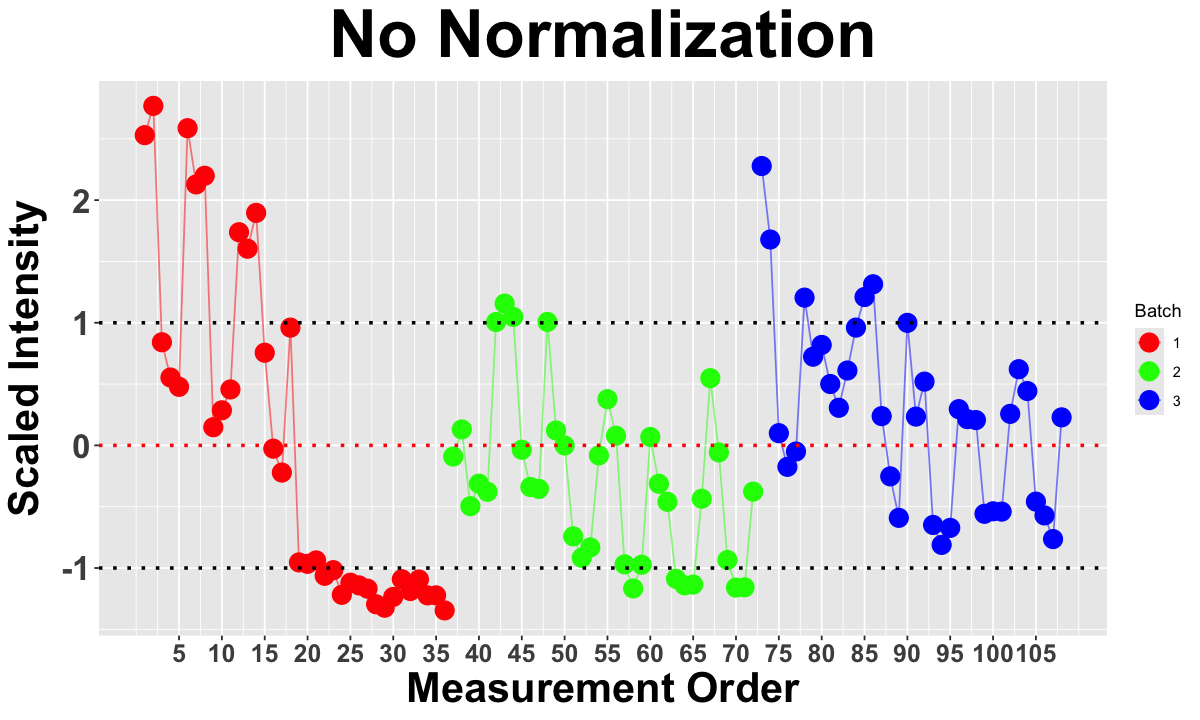

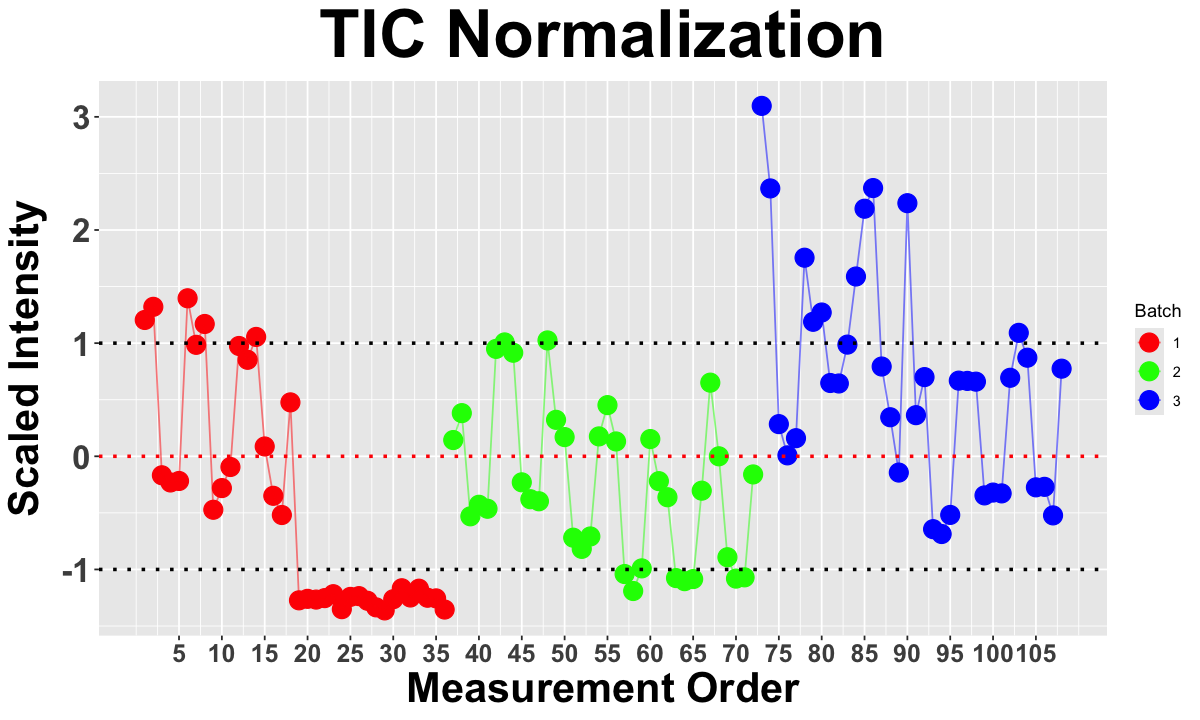

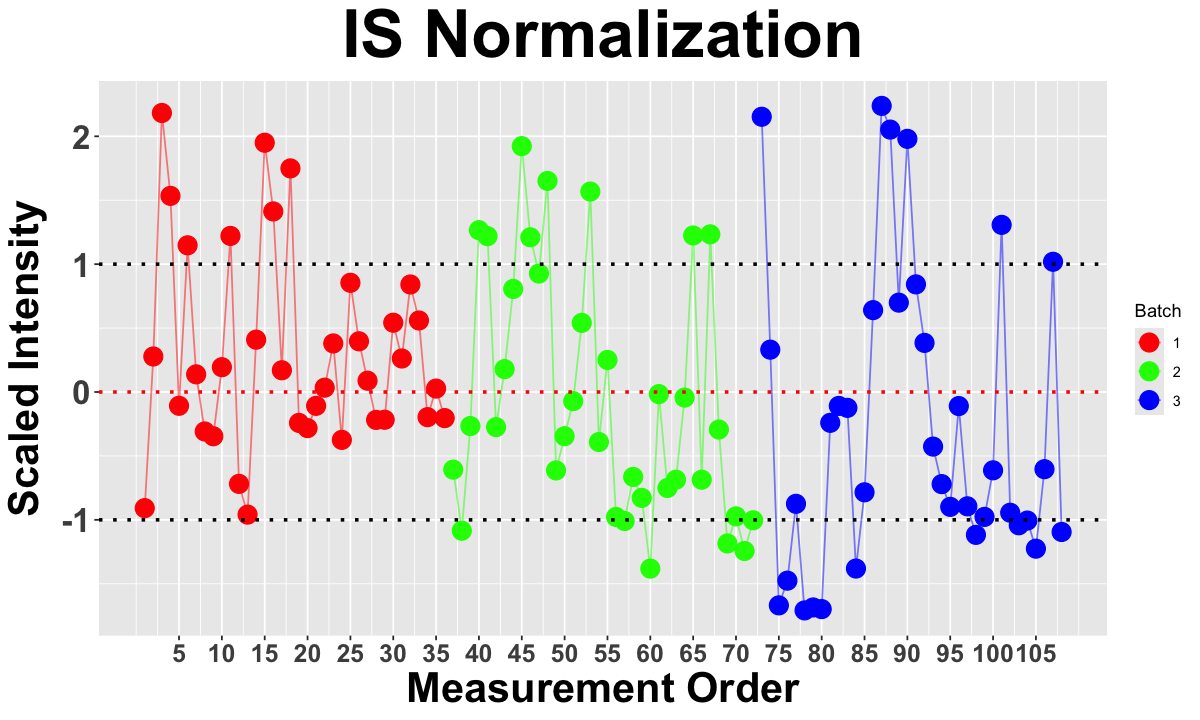

In [104]:
# Intensity Plot (Intensity vs Measurement Order) #

# load libraries #
library(RColorBrewer)
library(ggplot2)

# Functions #
# extract only qcs
extract_qcs_data <- function(dataset, sample_set) {
  pattern <- paste(sample_set, collapse = "|")
  
  # Extract tissue rows
  tissue_rows <- grep(pattern, rownames(dataset))
  
  # Subset dataframe to exclude tissue rows
  qcs_data <- dataset[-tissue_rows, , drop = FALSE]
  
  return(qcs_data)
}

## No Normalization Dataset ##
# get rid of tissue samples
qcs_batch_info_data <- extract_qcs_data(combined_batch_info_data, sample_set_1)

# ordering by batch then s_value
qcs_batch_info_data_ordered <- qcs_batch_info_data[order(qcs_batch_info_data$batch), ]
batch <- qcs_batch_info_data_ordered$batch

# extract s_value
row_names_qcs <- rownames(qcs_batch_info_data_ordered)
s_values <- as.numeric(sub(".*S(\\d+).*", "\\1", row_names_qcs))

qcs_batch_info_data_ordered$S <- s_values
qcs_batch_info_data_ordered <- qcs_batch_info_data_ordered[order(qcs_batch_info_data_ordered$batch, qcs_batch_info_data_ordered$S), ]

propranolol_intensity <- qcs_batch_info_data_ordered[,colnames(qcs_batch_info_data_ordered) == propranolol_mz_value_1, drop = FALSE]
propranolol_intensity_values <- as.numeric(unlist(propranolol_intensity))
propranolol_intensity <- scale(propranolol_intensity_values)

# intensity plot based on measurement_order
qcs_batch_info_data_ordered$measurement_order <- seq_len(nrow(qcs_batch_info_data_ordered))

plot_data_scaled <- data.frame(
  Measurement_order = qcs_batch_info_data_ordered$measurement_order,
  Batch = qcs_batch_info_data_ordered$batch,
  Intensity = propranolol_intensity
)

mean_intensity <- mean(plot_data_scaled$Intensity)
sd_intensity <- sd(plot_data_scaled$Intensity)
batch_unique <- unique(plot_data_scaled$Batch)
cat("\033[1mRed dotted line represents mean intensity (mean(scaled_intensity)). Black dotted lines represent standard deviation.(mean - std)\033[0m\n")

# setting colors
custom_colors <- c("1" = "red", "2" = "green", "3" = "blue") 

# Get the unique batch numbers
unique_batches <- unique(plot_data_scaled$Batch)

# Check if there are more than 3 unique batches
if (length(unique_batches) > 3) {
  additional_batches <- setdiff(unique_batches, names(custom_colors))
  # Generate additional colors using RColorBrewer palette
  additional_colors <- brewer.pal(length(additional_batches), "Set3")
  # Combine custom colors with additional colors
  all_colors <- c(custom_colors, setNames(additional_colors, additional_batches))
} else {
  all_colors <- custom_colors
}

# Create the intensity plot
options(repr.plot.width = 10, repr.plot.height = 6)  # Adjust width and height as desired
intensity_plot <- ggplot(plot_data_scaled, aes(x = Measurement_order, y = Intensity, color = factor(Batch))) +
  geom_point(size = 5) +  # Points colored by Batch
  geom_line(aes(group = Batch), alpha = 0.5) +  # Lines grouped by Batch
  geom_hline(yintercept = mean_intensity, linetype = "dotted", color = "red", linewidth = 1) +  # Red dotted line for mean
  geom_hline(yintercept = mean_intensity + sd_intensity, linetype = "dotted", color = "black", linewidth = 1) +  # Black dotted line for mean + SD
  geom_hline(yintercept = mean_intensity - sd_intensity, linetype = "dotted", color = "black", linewidth = 1) +  # Black dotted line for mean - SD
  labs(x = "Measurement Order", y = "Scaled Intensity", color = "Batch") +  # Axis labels
  scale_x_continuous(breaks = seq(5, max(plot_data_scaled$Measurement_order), by = 5)) +  # X-axis breaks
  scale_color_manual(values = all_colors) +  # Color scale
  ggtitle("No Normalization") +
  theme(
    plot.title = element_text(size = 40, hjust = 0.5, face = "bold"),  
    axis.title.x = element_text(size = 25, face = "bold"), 
    axis.title.y = element_text(size = 25, face = "bold"),  
    axis.text.x = element_text(size = 15, face = "bold"), 
    axis.text.y = element_text(size = 20, face = "bold")  
  )
print(intensity_plot)

# TIC normalization Dataset #
# get rid of tissue samples
qcs_batch_info_data <- extract_qcs_data(combined_batch_info_data_TIC, sample_set_1)

# ordering by batch then s value)
qcs_batch_info_data_ordered <- qcs_batch_info_data[order(qcs_batch_info_data$batch), ]

batch <- qcs_batch_info_data_ordered$batch
row_names_qcs <- rownames(qcs_batch_info_data_ordered)
s_values <- as.numeric(sub(".*S(\\d+).*", "\\1", row_names_qcs))

qcs_batch_info_data_ordered$S <- s_values
qcs_batch_info_data_ordered <- qcs_batch_info_data_ordered[order(qcs_batch_info_data_ordered$batch, qcs_batch_info_data_ordered$S), ]

propranolol_intensity <- qcs_batch_info_data_ordered[,colnames(qcs_batch_info_data_ordered) == propranolol_mz_value_1, drop = FALSE]
propranolol_intensity_values <- as.numeric(unlist(propranolol_intensity))
propranolol_intensity <- scale(propranolol_intensity_values)

# intensity plot based on measurement_order
qcs_batch_info_data_ordered$measurement_order <- seq_len(nrow(qcs_batch_info_data_ordered))

plot_data_scaled <- data.frame(
  Measurement_order = qcs_batch_info_data_ordered$measurement_order,
  Batch = qcs_batch_info_data_ordered$batch,
  Intensity = propranolol_intensity
)

rownames(plot_data_scaled) <- rownames(qcs_batch_info_data_ordered)
#print(plot_data_scaled)

mean_intensity_TIC <- mean(plot_data_scaled$Intensity)
sd_intensity <- sd(plot_data_scaled$Intensity)
batch_unique <- unique(plot_data_scaled$Batch)

# intensity plot
options(repr.plot.width = 10, repr.plot.height = 6)  # Adjust width and height as desired
intensity_plot_TIC <- ggplot(plot_data_scaled, aes(x = Measurement_order, y = Intensity, color = factor(Batch))) +
  geom_point(size = 5) +  # Points colored by Batch
  geom_line(aes(group = Batch), alpha = 0.5) +  # Lines grouped by Batch
  geom_hline(yintercept = mean_intensity_TIC, linetype = "dotted", color = "red", linewidth = 1) +  # Red dotted line for mean
  geom_hline(yintercept = mean_intensity_TIC + sd_intensity, linetype = "dotted", color = "black", linewidth = 1) +  # Black dotted line for mean + SD
  geom_hline(yintercept = mean_intensity_TIC - sd_intensity, linetype = "dotted", color = "black", linewidth = 1) +  # Black dotted line for mean - SD
  labs(x = "Measurement Order", y = "Scaled Intensity", color = "Batch") +  # Axis labels
  scale_x_continuous(breaks = seq(5, max(plot_data_scaled$Measurement_order), by = 5)) +  # X-axis breaks
  scale_color_manual(values = all_colors) +  # Color scale
  ggtitle("TIC Normalization") +
  theme(
    plot.title = element_text(size = 40, hjust = 0.5, face = "bold"),  
    axis.title.x = element_text(size = 25, face = "bold"),  
    axis.title.y = element_text(size = 25, face = "bold"),  
    axis.text.x = element_text(size = 15, face = "bold"),  
    axis.text.y = element_text(size = 20, face = "bold")  
  )
print(intensity_plot_TIC)

# IS normalization Dataset #
# get rid of tissue samples and ordering by batch
qcs_batch_info_data <- extract_qcs_data(combined_batch_info_data, sample_set_1)
qcs_batch_info_data_ordered <- qcs_batch_info_data[order(qcs_batch_info_data$batch), ]

# ordering by s-value
row_names_qcs <- rownames(qcs_batch_info_data_ordered)
s_values <- as.numeric(sub(".*S(\\d+).*", "\\1", row_names_qcs))

qcs_batch_info_data_ordered$S <- s_values
qcs_batch_info_data_ordered <- qcs_batch_info_data_ordered[order(qcs_batch_info_data_ordered$batch, qcs_batch_info_data_ordered$S), ]

# assign measurement order
qcs_batch_info_data_ordered$measurement_order <- seq_len(nrow(qcs_batch_info_data_ordered))
batch <- qcs_batch_info_data_ordered$batch

propranolol_intensity <- qcs_batch_info_data_ordered[,colnames(qcs_batch_info_data_ordered) == propranolol_mz_value_1, drop = FALSE] 
propranolol_intensity_values <- as.numeric(unlist(propranolol_intensity))

d7_propranolol_intensity <- qcs_batch_info_data_ordered[,colnames(qcs_batch_info_data_ordered) == d7_propranolol_mz_value_1, drop = FALSE] 
d7_propranolol_intensity_values <- as.numeric(unlist(d7_propranolol_intensity))

ratio_intensity <- propranolol_intensity_values / d7_propranolol_intensity_values
ratio_intensity <- scale(ratio_intensity)

# making data frame
plot_data_scaled <- data.frame(
  Measurement_order = qcs_batch_info_data_ordered$measurement_order,
  Batch = qcs_batch_info_data_ordered$batch,
  Intensity = ratio_intensity
)
mean_intensity_IS <- mean(plot_data_scaled$Intensity)
sd_intensity <- sd(plot_data_scaled$Intensity)
batch_unique <- unique(plot_data_scaled$Batch)

# Create the intensity plot
options(repr.plot.width = 10, repr.plot.height = 6)  # Adjust width and height as desired
intensity_plot_IS <- ggplot(plot_data_scaled, aes(x = Measurement_order, y = Intensity, color = factor(Batch))) +
  geom_point(size = 5) +  # Points colored by Batch
  geom_line(aes(group = Batch), alpha = 0.5) +  # Lines grouped by Batch
  geom_hline(yintercept = mean_intensity_IS, linetype = "dotted", color = "red", linewidth = 1) +  # Red dotted line for mean
  geom_hline(yintercept = mean_intensity_IS + sd_intensity, linetype = "dotted", color = "black", linewidth = 1) +  # Black dotted line for mean + SD
  geom_hline(yintercept = mean_intensity_IS - sd_intensity, linetype = "dotted", color = "black", linewidth = 1) +  # Black dotted line for mean - SD
  labs(x = "Measurement Order", y = "Scaled Intensity", color = "Batch") +  # Axis labels
  scale_x_continuous(breaks = seq(5, max(plot_data_scaled$Measurement_order), by = 5)) +  # X-axis breaks
  scale_color_manual(values = all_colors) +  # Color scale
  ggtitle("IS Normalization") +
  theme(
    plot.title = element_text(size = 40, hjust = 0.5, face = "bold"),  
    axis.title.x = element_text(size = 25, face = "bold"),  
    axis.title.y = element_text(size = 25, face = "bold"),  
    axis.text.x = element_text(size = 15, face = "bold"),  
    axis.text.y = element_text(size = 20, face = "bold")  
  )
print(intensity_plot_IS)

## Overview of Intensity Plot ##

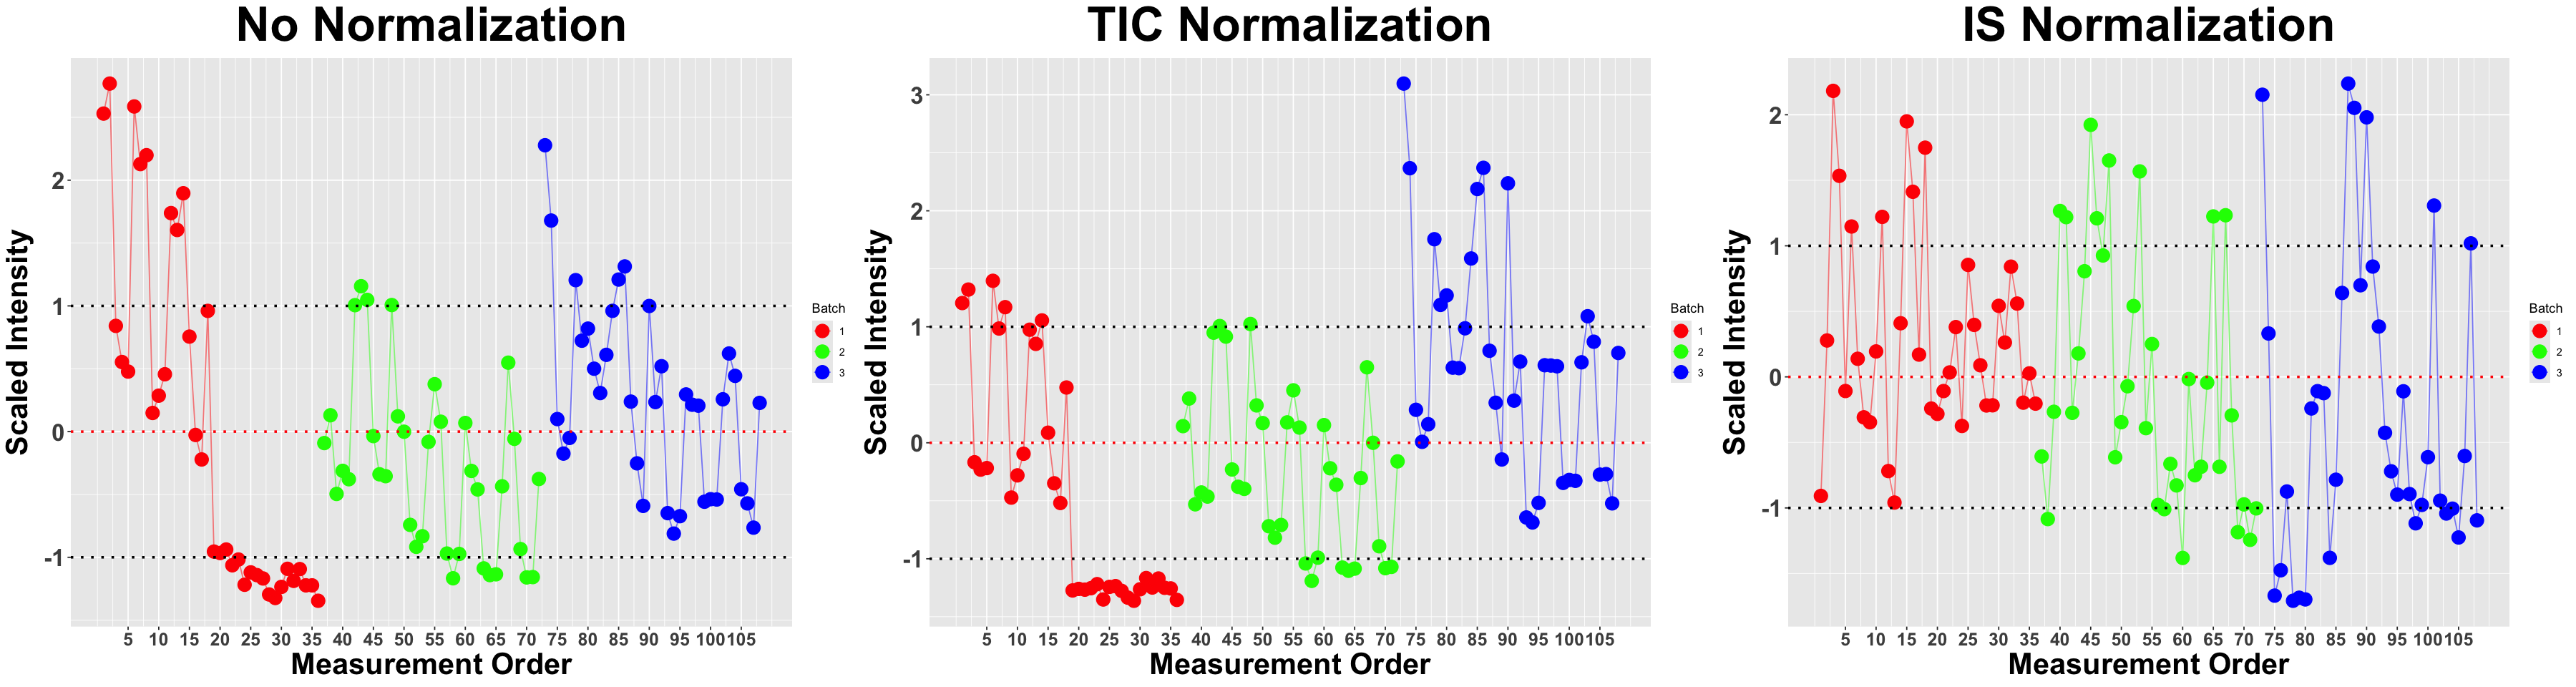

In [107]:
# Display combined
library(gridExtra)
options(repr.plot.width = 30, repr.plot.height = 8)  # Adjust width and height as desired
combined_intensity_plot <- grid.arrange(intensity_plot, intensity_plot_TIC, intensity_plot_IS, ncol = 3)

## 2. Violin Plot ##
<a id="violin_1"></a>

Violin plot represents the spreadout and variability of the QCS samples (both propranolol and D7_propranolol). It would have QCS peak intensity on the y-axis while each violins would represent each slide on the x-axis. 

Gray dotted line represents median


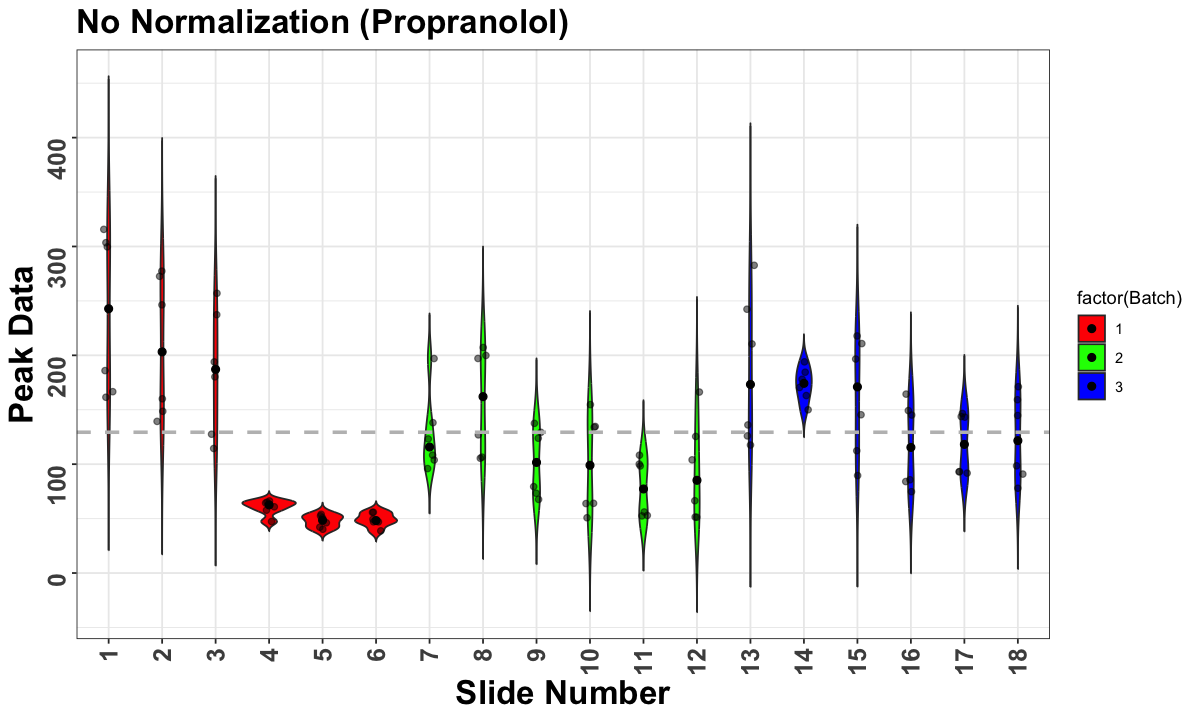

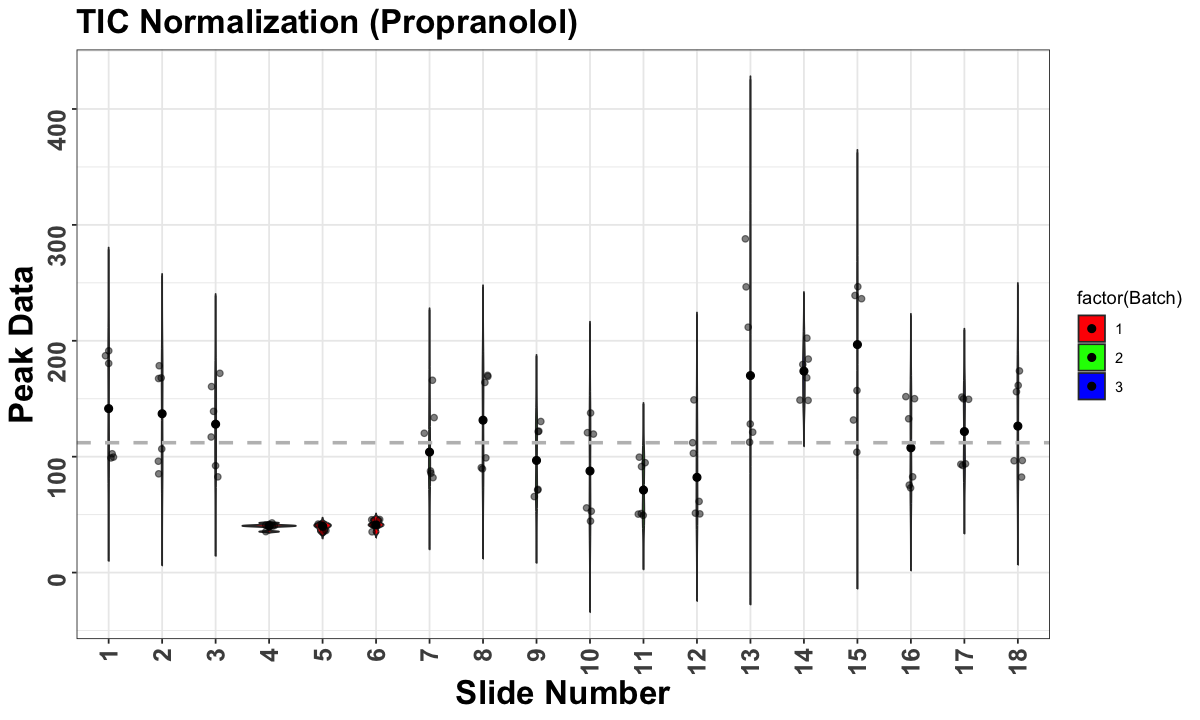

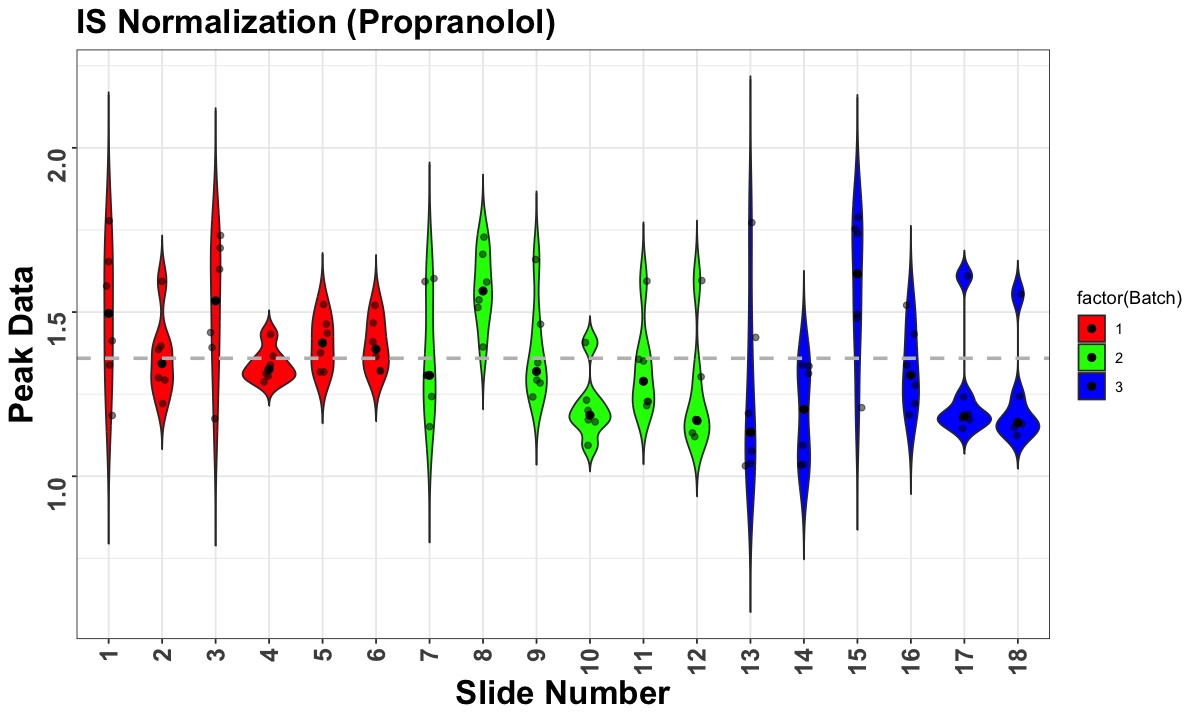

In [109]:
## Violin Plot ##

# Load library
library(ggplot2)
library(dplyr)
library(RColorBrewer)

# No Normalization Dataset #
# Transform and prepare the dataset
propranolol_data_trans <- as.data.frame(t(propranolol_data))
propranolol_data_trans[] <- lapply(propranolol_data_trans, as.numeric)

# Extract slide number
slide_number <- gsub("^.*S(\\d+)_.*", "\\1", names(propranolol_data_trans))
slide_number <- as.numeric(slide_number)

# Create violin plot data frame
violin_data <- data.frame(
  Slide = slide_number,
  Batch = propranolol_data$batch,
  Value = unlist(propranolol_data_trans[3, ])
)

# Sort the data frame based on the Slide column
violin_data <- violin_data %>%
  arrange(Slide)

# Find mean of all samples
mean_value <- mean(violin_data$Value)

# Define the colors for the first three batches
manual_colors <- c("1" = "red", "2" = "green", "3" = "blue")

# Get the unique batches in your data
unique_batches <- unique(violin_data$Batch)

# Determine the number of additional batches
additional_batches <- setdiff(unique_batches, names(manual_colors))

# Generate additional colors using a color ramp palette
if (length(additional_batches) > 0) {
  additional_colors <- colorRampPalette(brewer.pal(9, "Set3"))(length(additional_batches))
  additional_colors <- setNames(additional_colors, additional_batches)
} else {
  additional_colors <- c()
}

# Combine the manually defined colors with the additional colors
all_colors <- c(manual_colors, additional_colors)

# Plot the No Normalization data
cat("\033[1mGray dotted line represents median\033[0m\n")
options(repr.plot.width = 10, repr.plot.height = 6)  # Adjust width and height as desired
violin_plot_jit <- ggplot(violin_data, aes(x = factor(Slide), y = Value, fill = factor(Batch))) +
  geom_violin(position = position_dodge(width = 0.5), trim = FALSE, width = 1) +
  stat_summary(fun = median, geom = "point", shape = 20, size = 3, color = "black") +
  geom_point(position = position_jitter(width = 0.1), alpha = 0.5) + 
  geom_hline(yintercept = mean_value, linetype = "dashed", color = "gray", linewidth = 1) +
  scale_fill_manual(values = all_colors) +
  labs(x = "Slide Number", y = "Peak Data", title = "No Normalization (Propranolol)") +
  theme_bw() +
  theme(
    axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1, face = "bold"),
    axis.text.y = element_text(angle = 90, vjust = 0.5, hjust = 1, face = "bold"),
    axis.title = element_text(face = "bold", size = 20),  
    plot.title = element_text(face = "bold", size = 20),  
    axis.text = element_text(size = 15)  
  )
print(violin_plot_jit)

# TIC Normalization Dataset #
# Transform and prepare the dataset
propranolol_data_trans <- as.data.frame(t(propranolol_data_TIC))
propranolol_data_trans[] <- lapply(propranolol_data_trans, as.numeric)

# Extract slide number
slide_number <- gsub("^.*S(\\d+)_.*", "\\1", names(propranolol_data_trans))
slide_number <- as.numeric(slide_number)

# Create violin plot data frame
violin_data_TIC <- data.frame(
  Slide = slide_number,
  Batch = propranolol_data$batch,
  Value = unlist(propranolol_data_trans[3, ])
)

# Sort the data frame based on the Slide column
violin_data_TIC <- violin_data_TIC %>%
  arrange(Slide)

# Find mean of all samples
mean_value_TIC <- mean(violin_data_TIC$Value)

# Define the colors for the first three batches
manual_colors <- c("1" = "red", "2" = "green", "3" = "blue")

# Get the unique batches in your data
unique_batches <- unique(violin_data_TIC$Batch)

# Determine the number of additional batches
additional_batches <- setdiff(unique_batches, names(manual_colors))

# Generate additional colors using a color ramp palette
if (length(additional_batches) > 0) {
  additional_colors <- colorRampPalette(brewer.pal(9, "Set3"))(length(additional_batches))
  additional_colors <- setNames(additional_colors, additional_batches)
} else {
  additional_colors <- c()
}

# Combine the manually defined colors with the additional colors
all_colors <- c(manual_colors, additional_colors)

# Plot the TIC normalization data
options(repr.plot.width = 10, repr.plot.height = 6)  # Adjust width and height as desired
violin_plot_TIC_jit <- ggplot(violin_data_TIC, aes(x = factor(Slide), y = Value, fill = factor(Batch))) +
  geom_violin(position = position_dodge(width = 0.5), trim = FALSE, width = 1) +
  stat_summary(fun = median, geom = "point", shape = 20, size = 3, color = "black") +
  geom_point(position = position_jitter(width = 0.1), alpha = 0.5) + 
  geom_hline(yintercept = mean_value_TIC, linetype = "dashed", color = "gray", linewidth = 1) +
  scale_fill_manual(values = all_colors) +
  labs(x = "Slide Number", y = "Peak Data", title = "TIC Normalization (Propranolol)") +
  theme_bw() +
  theme(
    axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1, face = "bold"),
    axis.text.y = element_text(angle = 90, vjust = 0.5, hjust = 1, face = "bold"),
    axis.title = element_text(face = "bold", size = 20),  
    plot.title = element_text(face = "bold", size = 20),  
    axis.text = element_text(size = 15) 
  )
print(violin_plot_TIC_jit)

# IS Normalization Dataset #
# Transform and prepare the dataset
propranolol_data_trans <- as.data.frame(t(ratio_data))
propranolol_data_trans[] <- lapply(propranolol_data_trans, as.numeric)

# Extract slide number
slide_number <- gsub("^.*S(\\d+)_.*", "\\1", names(propranolol_data_trans))
slide_number <- as.numeric(slide_number)

# Create violin plot data frame
violin_data_IS <- data.frame(
  Slide = slide_number,
  Batch = ratio_data$batch,
  Value = unlist(propranolol_data_trans[3, ])
)

# Sort the data frame based on the Slide column
violin_data_IS <- violin_data_IS %>%
  arrange(Slide)

# Find mean of all samples
mean_value_IS <- mean(violin_data_IS$Value)

# Define the colors for the first three batches
manual_colors <- c("1" = "red", "2" = "green", "3" = "blue")

# Get the unique batches in your data
unique_batches <- unique(violin_data_IS$Batch)

# Determine the number of additional batches
additional_batches <- setdiff(unique_batches, names(manual_colors))

# Generate additional colors using a color ramp palette
if (length(additional_batches) > 0) {
  additional_colors <- colorRampPalette(brewer.pal(9, "Set3"))(length(additional_batches))
  additional_colors <- setNames(additional_colors, additional_batches)
} else {
  additional_colors <- c()
}

# Combine the manually defined colors with the additional colors
all_colors <- c(manual_colors, additional_colors)

# Plot the IS normalization data
options(repr.plot.width = 10, repr.plot.height = 6)  # Adjust width and height as desired
violin_plot_IS_jit <- ggplot(violin_data_IS, aes(x = factor(Slide), y = Value, fill = factor(Batch))) +
  geom_violin(position = position_dodge(width = 0.5), trim = FALSE, width = 1) +
  stat_summary(fun = median, geom = "point", shape = 20, size = 3, color = "black") +
  geom_point(position = position_jitter(width = 0.1), alpha = 0.5) + 
  geom_hline(yintercept = mean_value_IS, linetype = "dashed", color = "gray", linewidth = 1) +
  scale_fill_manual(values = all_colors) +
  labs(x = "Slide Number", y = "Peak Data", title = "IS Normalization (Propranolol)") +
  theme_bw() +
  theme(
    axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1, face = "bold"),
    axis.text.y = element_text(angle = 90, vjust = 0.5, hjust = 1, face = "bold"),
    axis.title = element_text(face = "bold", size = 20),  
    plot.title = element_text(face = "bold", size = 20),  
    axis.text = element_text(size = 15) 
  )
print(violin_plot_IS_jit)

Gray dotted line represents median


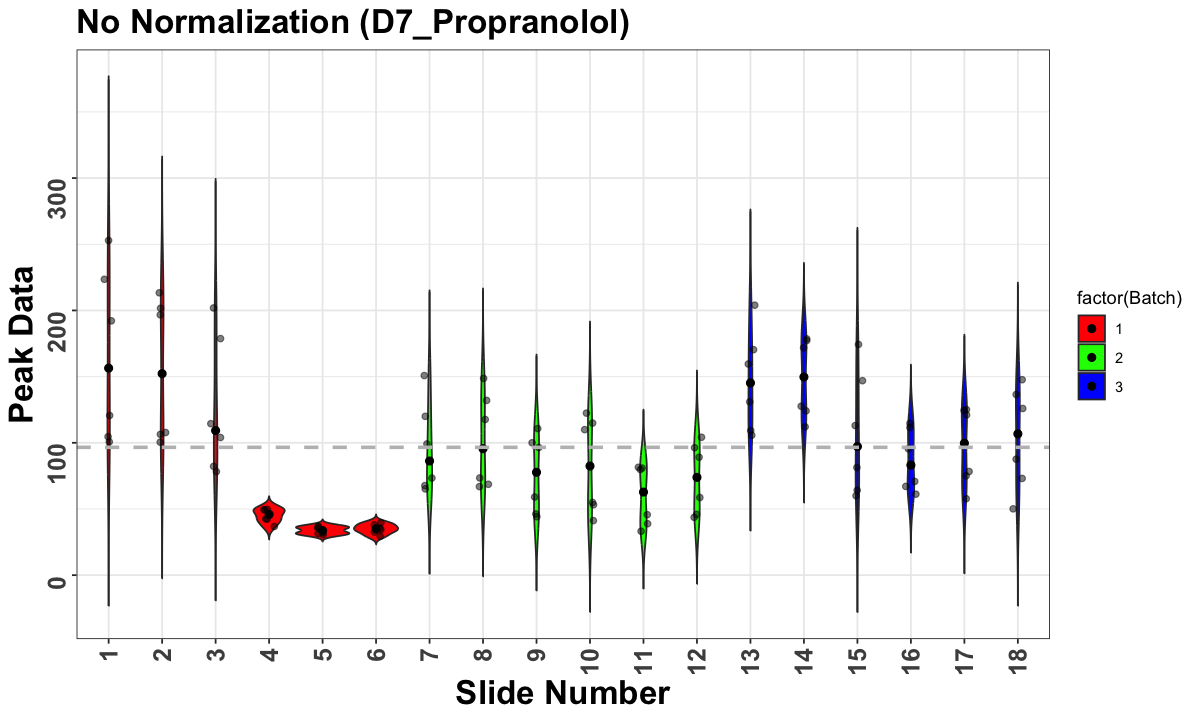

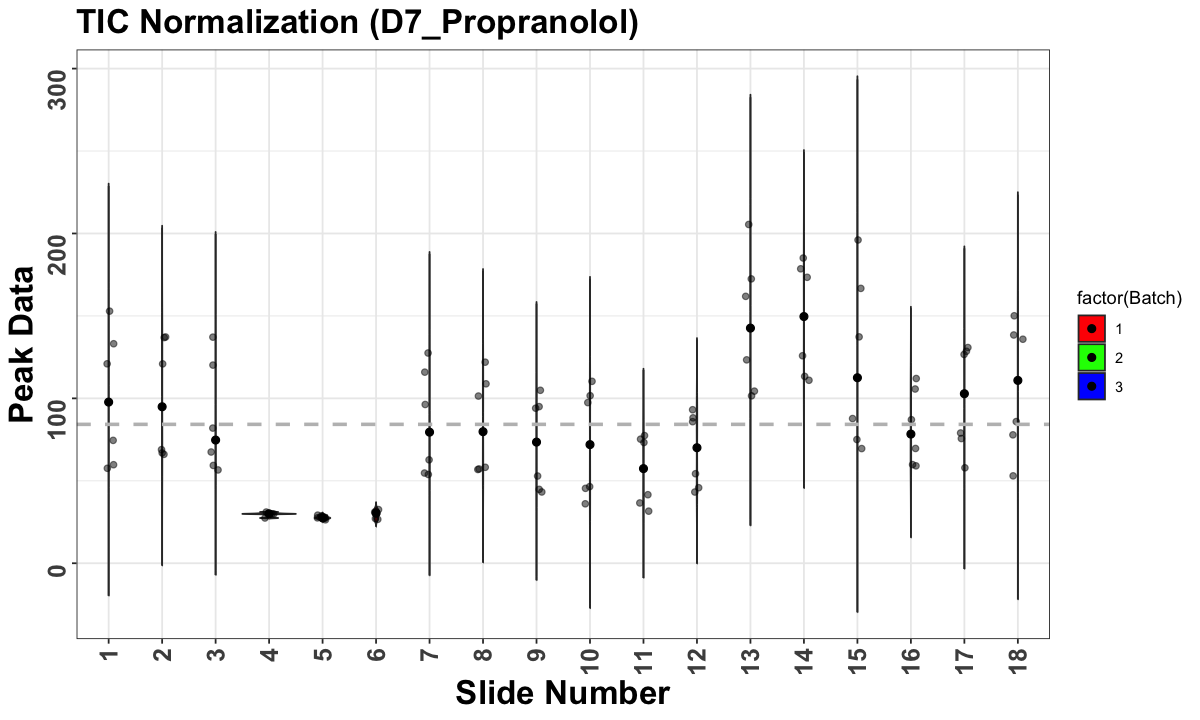

In [110]:
## Violin Plot ##

# Load library
library(ggplot2)
library(dplyr)
library(RColorBrewer)

# No Normalization Dataset #
# Transform and prepare the dataset
propranolol_data_trans <- as.data.frame(t(d7_propranolol_data))
propranolol_data_trans[] <- lapply(propranolol_data_trans, as.numeric)

# Extract slide number
slide_number <- gsub("^.*S(\\d+)_.*", "\\1", names(propranolol_data_trans))
slide_number <- as.numeric(slide_number)

# Create violin plot data frame
violin_data <- data.frame(
  Slide = slide_number,
  Batch = propranolol_data$batch,
  Value = unlist(propranolol_data_trans[3, ])
)

# Sort the data frame based on the Slide column
violin_data <- violin_data %>%
  arrange(Slide)

# Find mean of all samples
mean_value <- mean(violin_data$Value)

# Define the colors for the first three batches
manual_colors <- c("1" = "red", "2" = "green", "3" = "blue")

# Get the unique batches in your data
unique_batches <- unique(violin_data$Batch)

# Determine the number of additional batches
additional_batches <- setdiff(unique_batches, names(manual_colors))

# Generate additional colors using a color ramp palette
if (length(additional_batches) > 0) {
  additional_colors <- colorRampPalette(brewer.pal(9, "Set3"))(length(additional_batches))
  additional_colors <- setNames(additional_colors, additional_batches)
} else {
  additional_colors <- c()
}

# Combine the manually defined colors with the additional colors
all_colors <- c(manual_colors, additional_colors)

# Plot the No Normalization data
cat("\033[1mGray dotted line represents median\033[0m\n")
options(repr.plot.width = 10, repr.plot.height = 6)  # Adjust width and height as desired
violin_plot_jit_d7 <- ggplot(violin_data, aes(x = factor(Slide), y = Value, fill = factor(Batch))) +
  geom_violin(position = position_dodge(width = 0.5), trim = FALSE, width = 1) +
  stat_summary(fun = median, geom = "point", shape = 20, size = 3, color = "black") +
  geom_point(position = position_jitter(width = 0.1), alpha = 0.5) + 
  geom_hline(yintercept = mean_value, linetype = "dashed", color = "gray", linewidth = 1) +
  scale_fill_manual(values = all_colors) +
  labs(x = "Slide Number", y = "Peak Data", title = "No Normalization (D7_Propranolol)") +
  theme_bw() +
  theme(
    axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1, face = "bold"),
    axis.text.y = element_text(angle = 90, vjust = 0.5, hjust = 1, face = "bold"),
    axis.title = element_text(face = "bold", size = 20),  
    plot.title = element_text(face = "bold", size = 20),  
    axis.text = element_text(size = 15)  
  )
print(violin_plot_jit_d7)

# TIC Normalization Dataset #
# Transform and prepare the dataset
propranolol_data_trans <- as.data.frame(t(d7_propranolol_data_TIC))
propranolol_data_trans[] <- lapply(propranolol_data_trans, as.numeric)

# Extract slide number
slide_number <- gsub("^.*S(\\d+)_.*", "\\1", names(propranolol_data_trans))
slide_number <- as.numeric(slide_number)

# Create violin plot data frame
violin_data_TIC <- data.frame(
  Slide = slide_number,
  Batch = propranolol_data$batch,
  Value = unlist(propranolol_data_trans[3, ])
)

# Sort the data frame based on the Slide column
violin_data_TIC <- violin_data_TIC %>%
  arrange(Slide)

# Find mean of all samples
mean_value_TIC <- mean(violin_data_TIC$Value)

# Define the colors for the first three batches
manual_colors <- c("1" = "red", "2" = "green", "3" = "blue")

# Get the unique batches in your data
unique_batches <- unique(violin_data_TIC$Batch)

# Determine the number of additional batches
additional_batches <- setdiff(unique_batches, names(manual_colors))

# Generate additional colors using a color ramp palette
if (length(additional_batches) > 0) {
  additional_colors <- colorRampPalette(brewer.pal(9, "Set3"))(length(additional_batches))
  additional_colors <- setNames(additional_colors, additional_batches)
} else {
  additional_colors <- c()
}

# Combine the manually defined colors with the additional colors
all_colors <- c(manual_colors, additional_colors)

# Plot the TIC normalization data
options(repr.plot.width = 10, repr.plot.height = 6)  # Adjust width and height as desired
violin_plot_TIC_jit_d7 <- ggplot(violin_data_TIC, aes(x = factor(Slide), y = Value, fill = factor(Batch))) +
  geom_violin(position = position_dodge(width = 0.5), trim = FALSE, width = 1) +
  stat_summary(fun = median, geom = "point", shape = 20, size = 3, color = "black") +
  geom_point(position = position_jitter(width = 0.1), alpha = 0.5) + 
  geom_hline(yintercept = mean_value_TIC, linetype = "dashed", color = "gray", linewidth = 1) +
  scale_fill_manual(values = all_colors) +
  labs(x = "Slide Number", y = "Peak Data", title = "TIC Normalization (D7_Propranolol)") +
  theme_bw() +
  theme(
    axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1, face = "bold"),
    axis.text.y = element_text(angle = 90, vjust = 0.5, hjust = 1, face = "bold"),
    axis.title = element_text(face = "bold", size = 20),  
    plot.title = element_text(face = "bold", size = 20),  
    axis.text = element_text(size = 15) 
  )
print(violin_plot_TIC_jit_d7)

## Overview Violin Plot ##

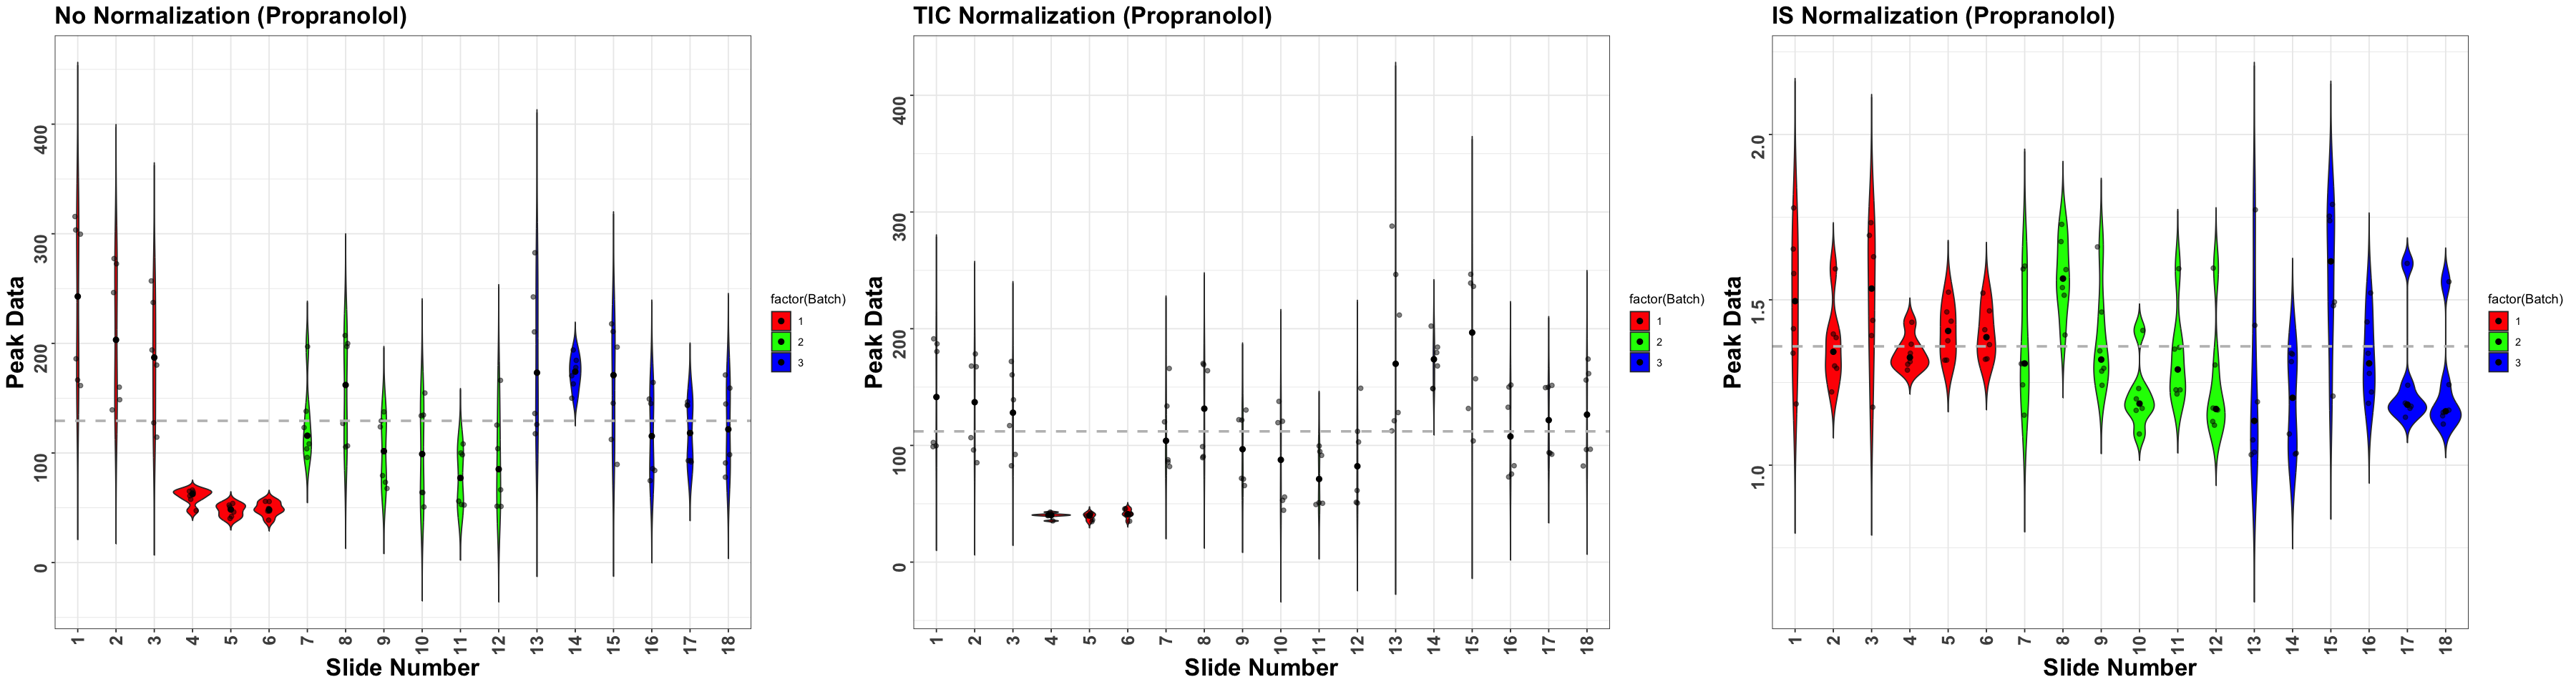

In [113]:
# Display Violin Plot (Propranolol)
library(gridExtra)
options(repr.plot.width = 30, repr.plot.height = 8)  # Adjust width and height as desired
combined_violin_plot <- grid.arrange(violin_plot_jit, violin_plot_TIC_jit, violin_plot_IS_jit, ncol = 3)

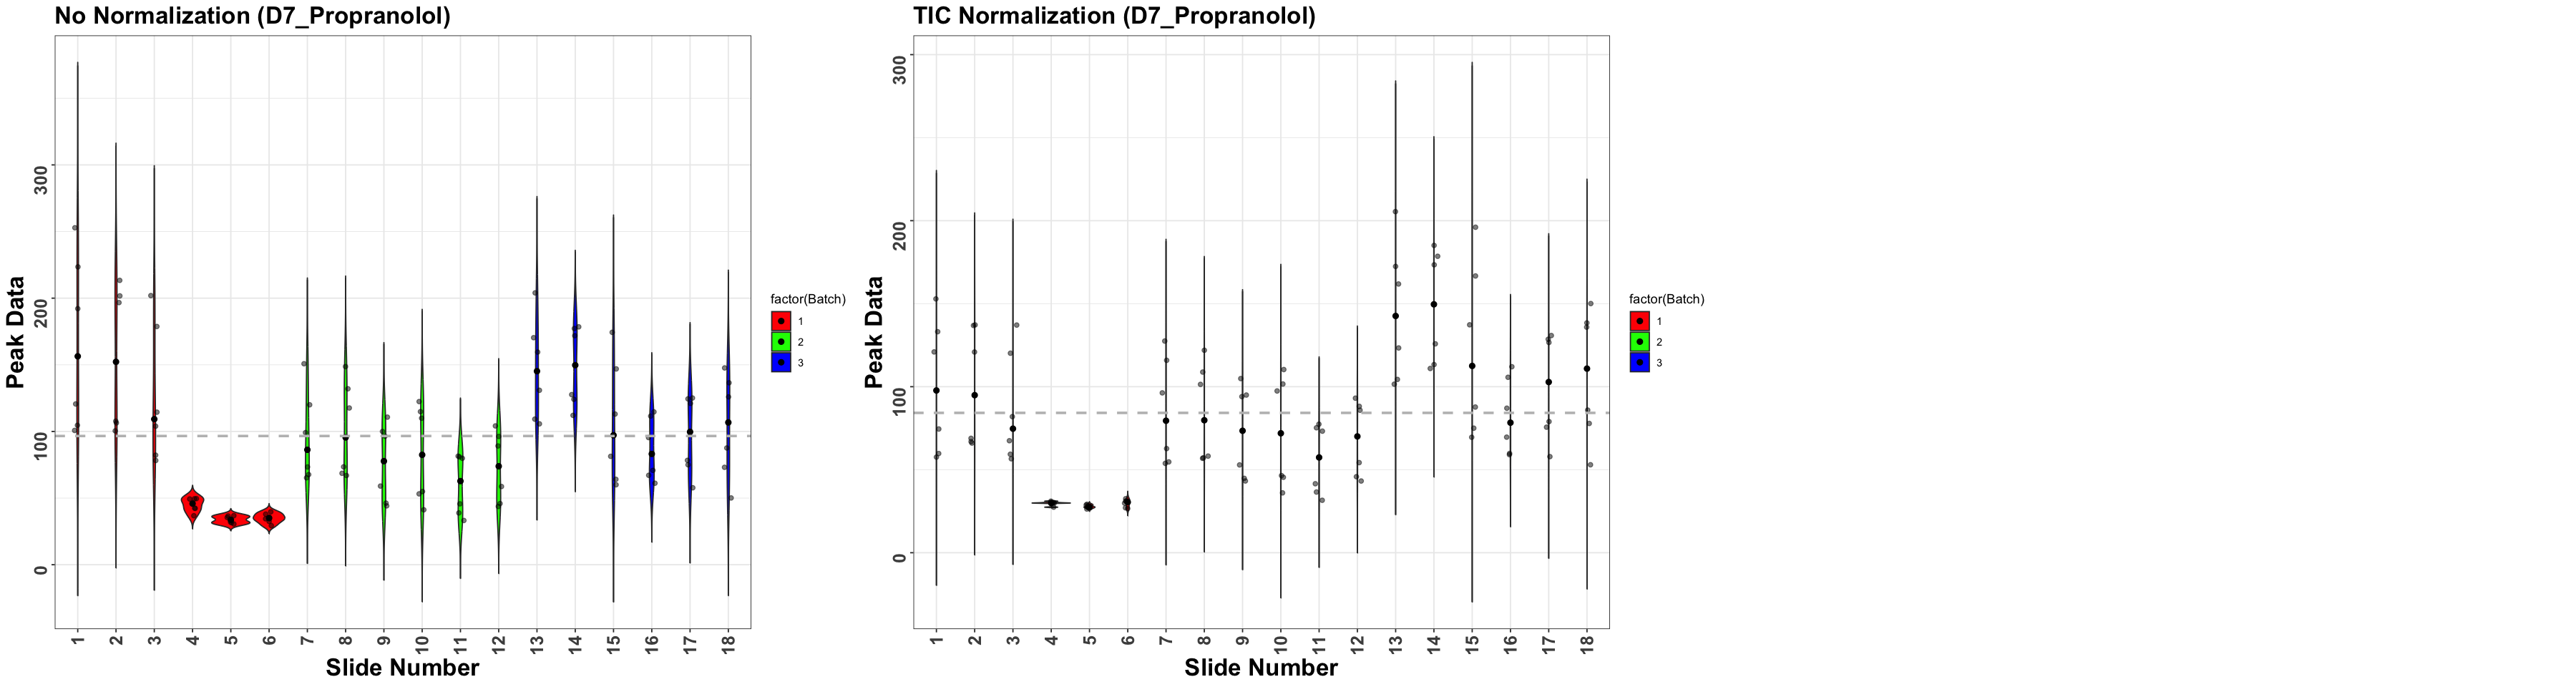

In [114]:
# Display Violin Plot (D7_Propranolol)
library(gridExtra)
options(repr.plot.width = 30, repr.plot.height = 8)  # Adjust width and height as desired
combined_violin_plot_d7 <- grid.arrange(violin_plot_jit_d7, violin_plot_TIC_jit_d7, ncol = 3)

<h1><u><b>Output</b></u></h1>
<a id="output_1"></a>

1. 3 Datasets as csv file (No norm, TIC norm, IS norm) in <b>dataset folder</b>
2. Excel sheets (No norm, TIC norm, IS norm) in <b>output folder</b>
3. Overview of Results in <b>result folder</b>

## Generate Excel sheets of each dataset in Intraday and Interday ##
You can open the excel sheets by left clicking the file in output and select "open in new browser tab", then you can see the excel sheet is downloaded.  

In [83]:
library(openxlsx)

# Prompt the user to input the number of batches
num_batches <- as.integer(readline("Enter the number of batches in your dataset: "))

create_batch_dataset_excel <- function(data, num_batches, propranolol_mz_value, file_name) {
  library(openxlsx)
  
  # Create a new Excel workbook
  wb <- createWorkbook()
  
  # Add sheets for Dataset, Intraday, and Interday
  sheet_names <- c("Dataset", paste0("Intraday ", 1:num_batches), "Interday")
  for (sheet_name in sheet_names) {
    addWorksheet(wb, sheet_name)
  }
  
  # Function to extract dataset for a specific batch
  extract_batch_dataset <- function(data, batch_number) {
    subset(data, batch == batch_number)
  }
  
  # Loop through each batch and write data to corresponding sheets
  for (i in 1:num_batches) {
    batch_dataset <- extract_batch_dataset(data, i)
    colnames(batch_dataset) <- sub("^X", "", colnames(batch_dataset))
    numeric_batch_dataset <- as.numeric(batch_dataset[, colnames(batch_dataset) == propranolol_mz_value, drop = TRUE])
    
    intraday_rsd <- calculate_rsd(numeric_batch_dataset)
    batch_dataset$intraday_rsd <- intraday_rsd
    batch_dataset <- as.data.frame(batch_dataset)
    
    # Write data to Intraday sheet
    writeData(wb, sheet = paste0("Intraday ", i), x = batch_dataset, rowNames = TRUE, colNames = TRUE)
  }
  
  # Calculate Interday RSD for all data
  numeric_interday_dataset <- as.numeric(data[, colnames(data) == propranolol_mz_value, drop = TRUE])
  interday_rsd <- calculate_rsd(numeric_interday_dataset)
  data$interday_rsd <- interday_rsd
  
  # Write data to Dataset and Interday sheets
  writeData(wb, sheet = "Dataset", x = data, rowNames = TRUE, colNames = TRUE)
  writeData(wb, sheet = "Interday", x = data, rowNames = TRUE, colNames = TRUE)
  
  # Save the workbook to a file, overwriting if it already exists
  file_path <- paste0("output/", file_name, ".xlsx")
  saveWorkbook(wb, file_path, overwrite = TRUE)
  
  return(file_path)
}

# Example usage:
if (exists("propranolol_data") && length(propranolol_data) > 0) {
    create_batch_dataset_excel(propranolol_data, num_batches, propranolol_mz_value_1, "NO_Norm_propranolol_batch_dataset")
}
if (exists("propranolol_data_TIC") && length(propranolol_data_TIC) > 0) {
    create_batch_dataset_excel(propranolol_data_TIC, num_batches, propranolol_mz_value_1, "TIC_Norm_propranolol_batch_dataset")
}
if (exists("ratio_data") && length(ratio_data) > 0) {
    create_batch_dataset_excel(ratio_data, num_batches, "ratio", "IS_Norm_propranolol_batch_dataset")
}

Enter the number of batches in your dataset:  3


[1] "output/NO_Norm_propranolol_batch_dataset.xlsx"

[1] "output/TIC_Norm_propranolol_batch_dataset.xlsx"

[1] "output/IS_Norm_propranolol_batch_dataset.xlsx"

## Overview of Results ##

Overview RSD Table Propranolol 
 
 
 Batch 
 No_norm 
 TIC_norm 
 IS_norm 
 
 
 
 
 Intraday 1 
 70.5% 
 63.51% 
 10.47% 
 
 
 Intraday 2 
 41.41% 
 38.88% 
 13.6% 
 
 
 Intraday 3 
 34.07% 
 36.26% 
 17.12% 
 
 
 Interday 
 52.05% 
 50.68% 
 14.11%

Overview RSD Table D7_Propranolol 
 
 
 Batch 
 No_norm 
 TIC_norm 
 
 
 
 
 Intraday 1 
 73.81% 
 66.96% 
 
 
 Intraday 2 
 39.71% 
 38.58% 
 
 
 Intraday 3 
 35.57% 
 36.63% 
 
 
 Interday 
 53.15% 
 53.14%

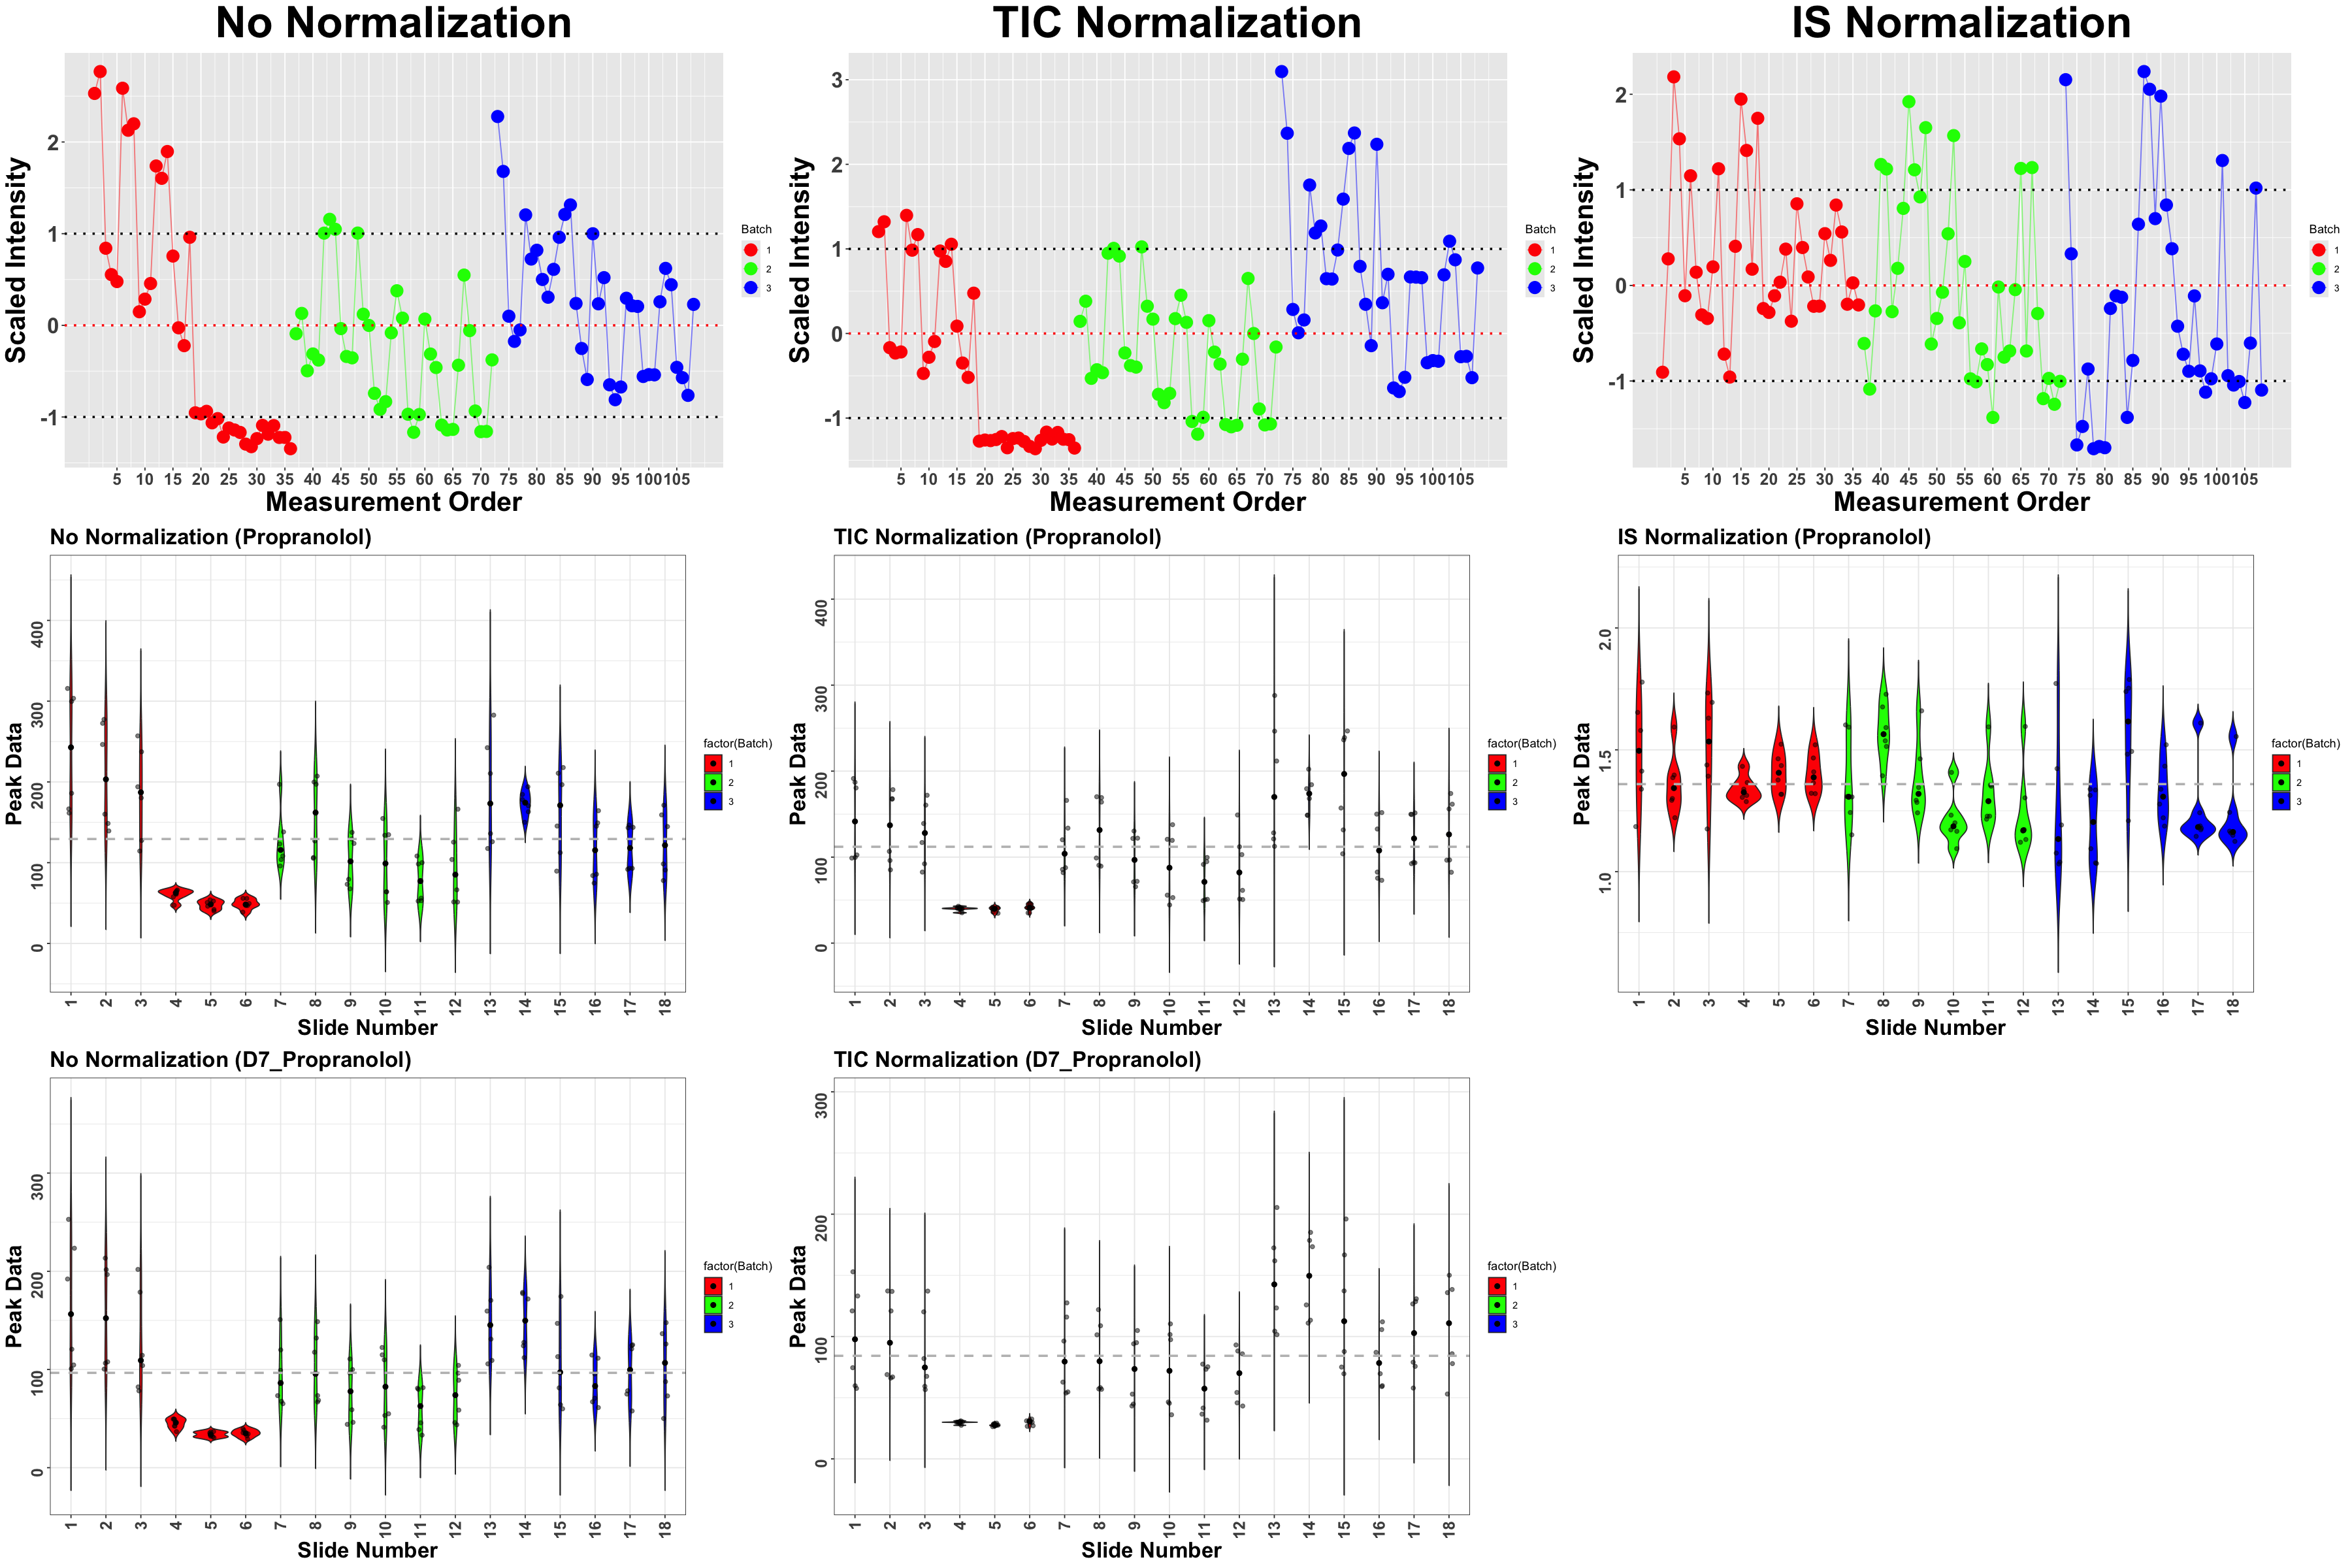

In [77]:
library(gridExtra)
options(repr.plot.width = 30, repr.plot.height = 20) 
overview_plots <- grid.arrange(combined_intensity_plot, combined_violin_plot, combined_violin_plot_d7, ncol = 1)
display_html(display_rsd_table_pro)
display_html(display_rsd_table_pro_d7)

In [85]:
# Saves each results in result folder 
if (!dir.exists("result")) {
  dir.create("result")
}

# Function to save the HTML table to a file
save_html_table <- function(html_content, file_path) {
  # Create a full HTML document with the necessary CSS and HTML structure
  html_document <- tags$html(
    tags$head(
      tags$meta(charset = "UTF-8"),
      tags$title("RSD Table"),
      tags$link(rel = "stylesheet", href = "https://cdnjs.cloudflare.com/ajax/libs/kableExtra/1.3.4/kableExtra.min.css"),
      tags$style(
        HTML(
          ".kable-table { width: auto !important; margin-left: auto !important; margin-right: auto !important; }"
        )
      )
    ),
    tags$body(
      HTML(html_content)
    )
  )
  
  # Write the full HTML document to the specified file path
  save_html(html_document, file = file_path)
}

# Saving QCS RSD html tables in result folder
save_html_table(display_rsd_table_pro, "result/display_rsd_table_pro.html")
save_html_table(display_rsd_table_pro_d7, "result/display_rsd_table_pro_d7.html")

# Saving the intensity plot to a file
file_path <- "result/intensity_plots.png"
ggsave(file_path, plot = combined_intensity_plot, width = 18, height = 25, dpi = 300)

# Saving the violin plot propranolol to a file
file_path <- "result/violin_propranolol_plots.png"
ggsave(file_path, plot = combined_violin_plot, width = 18, height = 25, dpi = 300)

# Saving the violin plot d7_propranolol to a file
file_path <- "result/violin_d7_propranolol_plots.png"
ggsave(file_path, plot = combined_violin_plot_d7, width = 18, height = 25, dpi = 300)